In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Table of Contents
1. Introduction
2. Methodology
    * Step 1: Data Pre-processing
    * Step 2: Data Cleaning
    * Step 3: Data Transformation
    * Step 4: Feature Engineering
    * Step 5: Machine Learning Model Design
3. Demonstration
4. Future Work

### 1. Introduction

According to the latest "Global Status Report On Road Safety 2018" by World Health Organization (WHO), regional rates of road traffic deaths in South-East Asia is among the highest at 20.7 deaths per 100,000 population and many of these road traffic accidents are caused by reckless driving behaviours. 

In order to reduce accident rates, the most effective way is to encourage better driving behaviour. This can be done 
by monitoring the driving behaviours of a driver with the help of inertia measure unit (IMU) such as accelerometer and gyroscope which are now commonly found in most modern smartphone nowadays. They can be used to detect the motion of a vehicle. By training a machine learning model to learn the information from these sensors data, we can build a model to classify dangerous driving behaviours, such as harsh braking and hard acceleration and classify whether a driver is driving recklessly.

In this project, we are going to derive a machine learning model that can detect dangerous driving trips from the telematics data collected throughout a trip, including from IMU sensors and GPS. 

***

### 2. Methodology

#### **Step 1: Data Pre-processing**

Raw Data Description: 
1. Contain 16,135,561 telematics data collected from 20,000 trips. 
2. Data collected includes accuracy inferred by GPS, bearing, triaxial accelerometer and gyroscope readings, speed and the time of record of these data. 

However, as some of the trips contains multiple conflicting labels, after excluding them out, we are left with 16,116,704 telematics data from 19,982 trips. After that, we split our datasets into 90% train set and 10% hold-out test set using stratified sampling. <br>

All the processes mentioned above can be found in **supporting_scripts/dataprep.ipynb** notebook.

***

#### **Step 2: Data Cleaning**

In [2]:
tele = pd.read_csv("data/ori_tele.csv", dtype={'bookingID': 'object'})
label = pd.read_csv("data/ori_labels.csv", dtype={'bookingID': 'object'}).sample(frac=0.5, random_state=8) # sample 50% of the data for faster analysis
tele = tele.loc[tele.bookingID.isin(label.bookingID)]

In [3]:
tele.loc[:, ['Accuracy', 'second', 'Speed']].describe()

,Accuracy,second,Speed
count,7.233610e+06,7.233610e+06,7.233610e+06
mean,1.153369e+01,7.106849e+03,8.924708e+00
std,8.653695e+01,2.007422e+06,8.059694e+00
min,7.500000e-01,0.000000e+00,-2.000000e+00
25%,3.900000e+00,2.400000e+02,9.900000e-01
50%,4.288000e+00,5.180000e+02,7.420950e+00
75%,8.000000e+00,8.610000e+02,1.535661e+01
max,6.063000e+03,6.193166e+08,1.480186e+02


In [4]:
print("Proportion of (-1 mps) out of all negative speed records", sum(tele.Speed == -1) / sum(tele.Speed < 0))

Proportion of (-1 mps) out of all negative speed records 0.989031315317315


There are some ***counterintuitive readings*** in our data. 
1. 'Speed' can be lower than 0. 
2. There are values in 'second' that exceed 10^8.

Upon further investigation, most of these errorneous readings are recorded when the ***accuracy inferred by GPS is very low***. This can happen when GPS signal is not strong or when the device had lost its GPS signals. <br>

Besides, it was also observed that "-1" appeared most frequently among the negative records in speed. This may be an indication of the same error during data collection. To prevent our model from learning these noises in data, we will filter them out.

In [5]:
# filter out GPS data with low accuracy and speed equals -1
tele = tele.loc[(tele.Accuracy <= np.percentile(tele.Accuracy, 95)) & (tele.Speed != -1)]

***

#### **Step 3: Data Transformation**

One of the major problem of using IMU sensors data that are collected from smartphone is that different driver may mount their smartphone in the vehicle in ***different orientation / position***, therefore, making the interpretation of the axes of accelerometer and gyroscope difficult. <br>

To tackle this problem, we are going to transform the readings from accelerometer and gyroscope in different ways:
>**Accelerometer**: <br>
Since vehicles move in one direction, only one of the axes will show large variation in the readings while others axes will typically have small fluctuation only. Assuming the readings of accelerometer are represented in a vector space, we can summarise all three axes by finding the ***magnitude of acceleration*** using the following formula: $\sqrt{ (acceleration_x)^{2} +  (acceleration_y)^{2} +  (acceleration_x)^{2}}$ <br>

>**Gyroscope**: <br>
Unlike accelerometer, the distribution of gyroscope readings in all three axes are somewhat similar. Therefore, we decided to use ***principal component analysis (PCA)*** to represent the triaxial gyroscope data in a lower dimension by taking advantange of the correlations among these axes. Representing the triaxial data in lower dimension will be very helpful for classification and clustering algorithms that will be used later on as it reduces the risk of curse of dimensionality. 

##### Distribution of gyroscope data

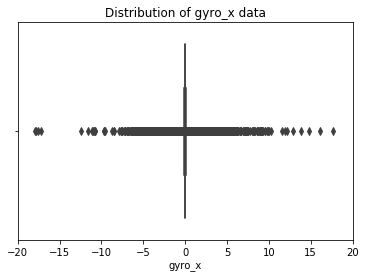

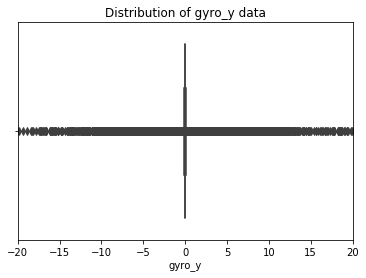

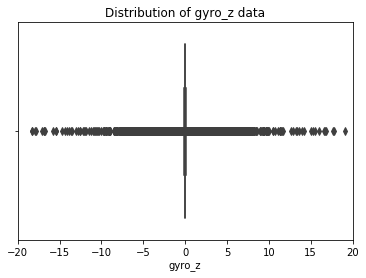

In [6]:
for col in ['gyro_x', 'gyro_y', 'gyro_z']:
    sns.boxplot(tele[col])
    plt.title("Distribution of {} data".format(col))
    plt.xlim(-20, 20)
    plt.show()

##### Principal Component Analysis Of Gyroscope Data

In [7]:
from sklearn.decomposition import PCA
pca_gyro = PCA().fit(tele.loc[:, ['gyro_x', 'gyro_y', 'gyro_z']])
pca_gyro.explained_variance_ratio_

array([0.70202554, 0.16086768, 0.13710679])

The first principal component can explain the variations in gyroscope data fairly well (around 70%). Thus, we will only keep the **first component** for modelling.

***

#### **Step 4: Feature Engineering**
Since one trip only has 1 label (0 or 1) but up to thousands of telematics data, we need to create aggregate features that can summarise these telematics data before training a classification model.

To do this, we are going to use 3 approaches:
> **1. Statistical summary of telematics data** <br>
This includes measure of central tendency (e.g: mean, median) and measure of dispersion (e.g: standard deviation). <br>
* Strength: Able to summarise the distribution of readings for the entire trip very well. <br>
* Weakness: Ignores time-related events. For example, a long trip that involves driving in town area and expressways with average speed of 80 kmph is indifferent from a short trip that involves speeding in town area with average speed of 80 kmph. 

> **2. Count outlying driving behaviours based on telematics readings** <br>
For example, if the 25th and 75th percentile of training data gyroscope readings are -0.03 rad/s and 0.03 rad/s respectively, we will count the number of times a driver exceed these limit (lower than -0.03 rad/s or higher than 0.03 rad/s) throughout a trip. Exceeding the norms might suggest that the driver is behaving dangerously, such as rapid turns and fast lane-changes. <br> 
* Strength: Fair comparison against the population (all drivers). <br>
* Weakness: Training data collected can be biased. 

> **3. Sliding windows aggregated features** <br>
A window size of 8 seconds (with 50% overlapping region) is slided over the telematics data and summary statistics are computed for each windows. We then cluster these windows using K-means clustering algorithm. These clusters can be treated as if they represent certain driving behaviour, such as harsh braking and hard acceleration during the 8 second interval captured. The number of occurences for each of these behaviours (clusters) is then used as feature for the trip. <br>
* Strength: Able to capture all time-related events that happened within 8 seconds interval, such as harsh braking, hard acceleration. <br>
* Weakness: Difficult to tell what the clusters represent as we are using unsupervised learning. <br>

A total of **52 features** are created from these 3 approaches. Since every type of features have their own strengths and weaknesses, we combine all of them and let our model to learn the interaction among these features.

NOTE: Sliding windows method is the most common way to handle IMU sensors data and had been used for several applications such as human activity recognition and driving behaviour classification. However, for this problem, we do not have labels for specific driving behaviours. Thus, clustering algorithms are used instead to group these telematics data into arbitrary driving behaviours. <br>

**Reference**:<br> 
1. Ferreira, J., Carvalho, E., Ferreira, B., de Souza, C., Suhara, Y., Pentland, A. and Pessin, G. (2017). *Driver behaviour profiling: An investigation with different smartphone sensors and machine learning*. PLOS ONE, 12(4). p.e0174959 <br>
2. Burns, D., Leung, N., Hardisty, M., Whyne, C., Henry, P. and McLachlin, S. (2018). *Shoulder Physiotherapy Exercise Recognition: Machine Learning the Inertial Signals from a Smartwatch.* Physiological Measurement, 39(7), p.075007

***

#### **Step 5: Machine Learning Model Design**
Different machine learning models may learn different interactions among features even though given the same training dataset. To make use of the 'wisdom of the crowd', we will stack our models in 3 different layers by combining the outputs from weak and strong models. The architecture of our stacked models are shown in the following diagram:

<img src="img/stacked_model.png" width="500">

During initial stage of training, we randomly show 70% of all our features to the following models: <br>
1. Logistic Regression
2. Naive Bayes (NB)
3. Linear Discriminant Analysis (LDA)
4. XGBoost
5. Multilayer Perceptron Classifier (MLP)

Experimental results showed that NB and MLP are weaker learners compared to others for this particular train data. Therefore, our layer 1 consists of these two models. <br>

Next, we average the predictions from models in layer 1 and add that as new features to our input data and showed them to layer 2 models, which consists of logistic regression, LDA and XGBoost. <br> 

The predictions made by layer 2 models are then passed to our meta learner (XGBoost) as input, and final prediction is made by the meta learner. <br>

Note: Script for model training can be found at
1. "supporting_scripts/train_init.ipynb" for initial stage training.
2. "supporting_scripts/train_stage1.ipynb" for training layer 1 weak learners.
3. "supporting_scripts/train_stage2_3.ipynb" for training layer 2 strong learners and layer 3 meta learner.

***

### 3. Demonstration
The following section will demonstrate how to use our pre-trained model and showcase the performance of the model on our self-defined hold-out test set.

In [8]:
import predict_model

# set up the classifier model by loading the weights
classifier = predict_model.DangerousDrivingClassifier('model_weights')

# predict raw telematics data
output = classifier.predict("benchmark/bm_tele.csv")

... (0/5) reading data ... 
... (1/5) cleaning data ... 
... (2/5) transforming data ... 
... (3/5) generating feature (Type 1: Statistical Description) ... 
... (4/5) generating feature (Type 2: Counting Outlying Behaviours) ... 
... (5/5) generating feature (Type 3: Sliding Window) ... 
    (WARNING! This process may take up many RAM memory. Please allocate enough memory.)
    Side Note: This may take awhile, please be patient. :)
Done!


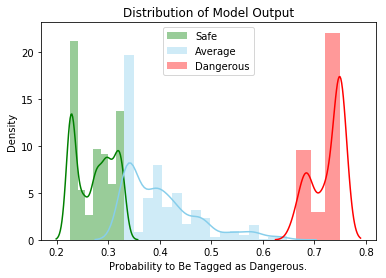

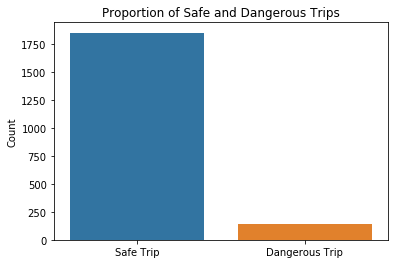

In [9]:
# a summary report on the predictions can be generated using generate_report() method
classifier.generate_report()

##### Testing our model on self-defined hold-out test set

In [12]:
# annotate our predicted output with true labels (Note: 'all_label' DataFrame contains the label for all trips given to us)
all_label = pd.read_csv("data/ori_labels.csv", dtype={'bookingID': 'object'})
annotated_output = pd.merge(output, all_label, on='bookingID', suffixes=('_pred', '_true'))

In [13]:
# check our prediction's score
from sklearn import metrics
print("Evaluation Metrics On Hold-out Test Data")
print("ROC :", metrics.roc_auc_score(annotated_output.label_true, annotated_output.prob))
print("Accuracy:", metrics.accuracy_score(annotated_output.label_true, annotated_output.label_pred))

Evaluation Metrics On Hold-out Test Data
ROC : 0.7513326639892906
Accuracy: 0.7852852852852853


Experimental results showed that our model had achieved ROC score of 0.7513 and accuracy of 0.7853.

***

### 4. Future Work
1. **Improve Model Interpretability** <br>
The major drawback of using complex models, such as stacked models is that they are generally hard to be interpreted. One of the possible ways to interpret these complex models are by using SHAP (SHapley Additive exPlanations) method. However, current open-source implementation of SHAP method does not support stacked models. Thus, new efforts are needed to make this happen. <br>

2. **Normalizing Gyroscope and Accelerometer Data** <br>
Although the methods discussed in (Section 3: Data Transformation) had been proven to work on the our IMU data, transforming data will still undoubtedly caused some loss in information. A better alternative is to normalise these data using signal processing methods such as filtering. More domain knowledge on signal processing are required. 